In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from os.path import isfile, join
import random

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras import metrics
import tensorflow as tf

In [2]:
DIR = "./dataset/kaggle_3m"
INPUT_CHANNELS = 3
TARGET_CHANNELS = 1
SIZE = 256
BATCH_SIZE = 32

In [3]:
mri_images_with_tumer = []
mri_images_without_tumer = []
mask_images_with_tumer = []
mask_images_without_tumer = []
patients = os.listdir(DIR)
for patient in tqdm(patients):
    if isfile(join(DIR, patient)) == False:
        images = os.listdir(join(DIR, patient))
        mask_images = list(filter(lambda x: x.find('mask') != -1, images))
        mri_images = list(filter(lambda x: x.find('mask') == -1, images))
        
        for mask_image in mask_images:
            mask = np.asarray(load_img(
                join(DIR, patient, mask_image), 
                target_size=(SIZE, SIZE), 
                color_mode="grayscale"))
            if np.amax(mask) != 0:
                mri_images_with_tumer.append(join(patient, mask_image.replace('_mask', '')))
                mask_images_with_tumer.append(join(patient, mask_image))
            else:
                mri_images_without_tumer.append(join(patient, mask_image.replace('_mask', '')))
                mask_images_without_tumer.append(join(patient, mask_image))

100%|██████████| 112/112 [00:01<00:00, 65.05it/s]


Total MRI images:  3929
Total mask images:  3929
Total images with tumer:  1373
Total images without tumer:  2556


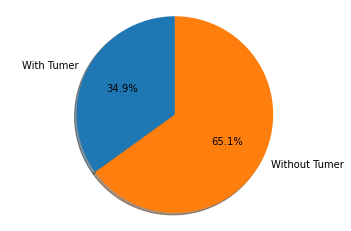

In [4]:
random.Random(1337).shuffle(mri_images_with_tumer)
random.Random(1337).shuffle(mask_images_with_tumer)
random.Random(1337).shuffle(mri_images_without_tumer)
random.Random(1337).shuffle(mask_images_without_tumer)


print("Total MRI images: ", len(mri_images_with_tumer) + len(mri_images_without_tumer))
print("Total mask images: ", len(mask_images_with_tumer) + len(mask_images_without_tumer))
print("Total images with tumer: ", len(mri_images_with_tumer))
print("Total images without tumer: ", len(mri_images_without_tumer))

labels = ['With Tumer', 'Without Tumer']
count = [len(mri_images_with_tumer), len(mri_images_without_tumer)]

fig, ax = plt.subplots()
ax.pie(count, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [5]:
mri_images_with_tumer = np.array(mri_images_with_tumer)
mri_images_without_tumer = np.array(mri_images_without_tumer)
mask_images_with_tumer = np.array(mask_images_with_tumer)
mask_images_without_tumer = np.array(mask_images_without_tumer)

In [6]:
with_tumer_val_images = 300
without_tumer_val_images = 600

with_tumer_test_images = 10
without_tumer_test_images = 5

train_images = np.concatenate(
    (mri_images_with_tumer[:-with_tumer_val_images-with_tumer_test_images], 
     mri_images_without_tumer[:-without_tumer_val_images-without_tumer_test_images]), 
    axis = 0)

val_images = np.concatenate(
    (mri_images_with_tumer[-with_tumer_val_images-with_tumer_test_images:-with_tumer_test_images], 
     mri_images_without_tumer[-without_tumer_val_images-without_tumer_test_images:-without_tumer_test_images]), 
    axis = 0)
test_images = np.concatenate(
    (mri_images_with_tumer[-with_tumer_test_images:], 
     mri_images_without_tumer[-without_tumer_test_images:]), 
    axis = 0)

train_targets = np.concatenate(
    (mask_images_with_tumer[:-with_tumer_val_images-with_tumer_test_images], 
     mask_images_without_tumer[:-without_tumer_val_images-without_tumer_test_images]), 
    axis = 0)

val_targets = np.concatenate(
    (mask_images_with_tumer[-with_tumer_val_images-with_tumer_test_images:-with_tumer_test_images], 
     mask_images_without_tumer[-without_tumer_val_images-without_tumer_test_images:-without_tumer_test_images]), 
    axis = 0)

test_targets = np.concatenate(
    (mask_images_with_tumer[-with_tumer_test_images:], 
     mask_images_without_tumer[-without_tumer_test_images:]), 
    axis = 0)


print("train_images: ", train_images.shape)
print("train_targets: ", train_targets.shape)
print("val_images: ", val_images.shape)
print("val_targets: ", val_targets.shape)
print("test_images: ", test_images.shape)
print("test_targets: ", test_targets.shape)

train_images:  (3014,)
train_targets:  (3014,)
val_images:  (900,)
val_targets:  (900,)
test_images:  (15,)
test_targets:  (15,)


In [7]:
random.Random(37).shuffle(train_images)
random.Random(37).shuffle(train_targets)
random.Random(37).shuffle(val_images)
random.Random(37).shuffle(val_targets)

In [8]:
train_df = pd.DataFrame(data={'mris': train_images, 'masks': train_targets})
val_df = pd.DataFrame(data={'mris': val_images, 'masks': val_targets})
test_df = pd.DataFrame(data={'mris': test_images, 'masks': test_targets})

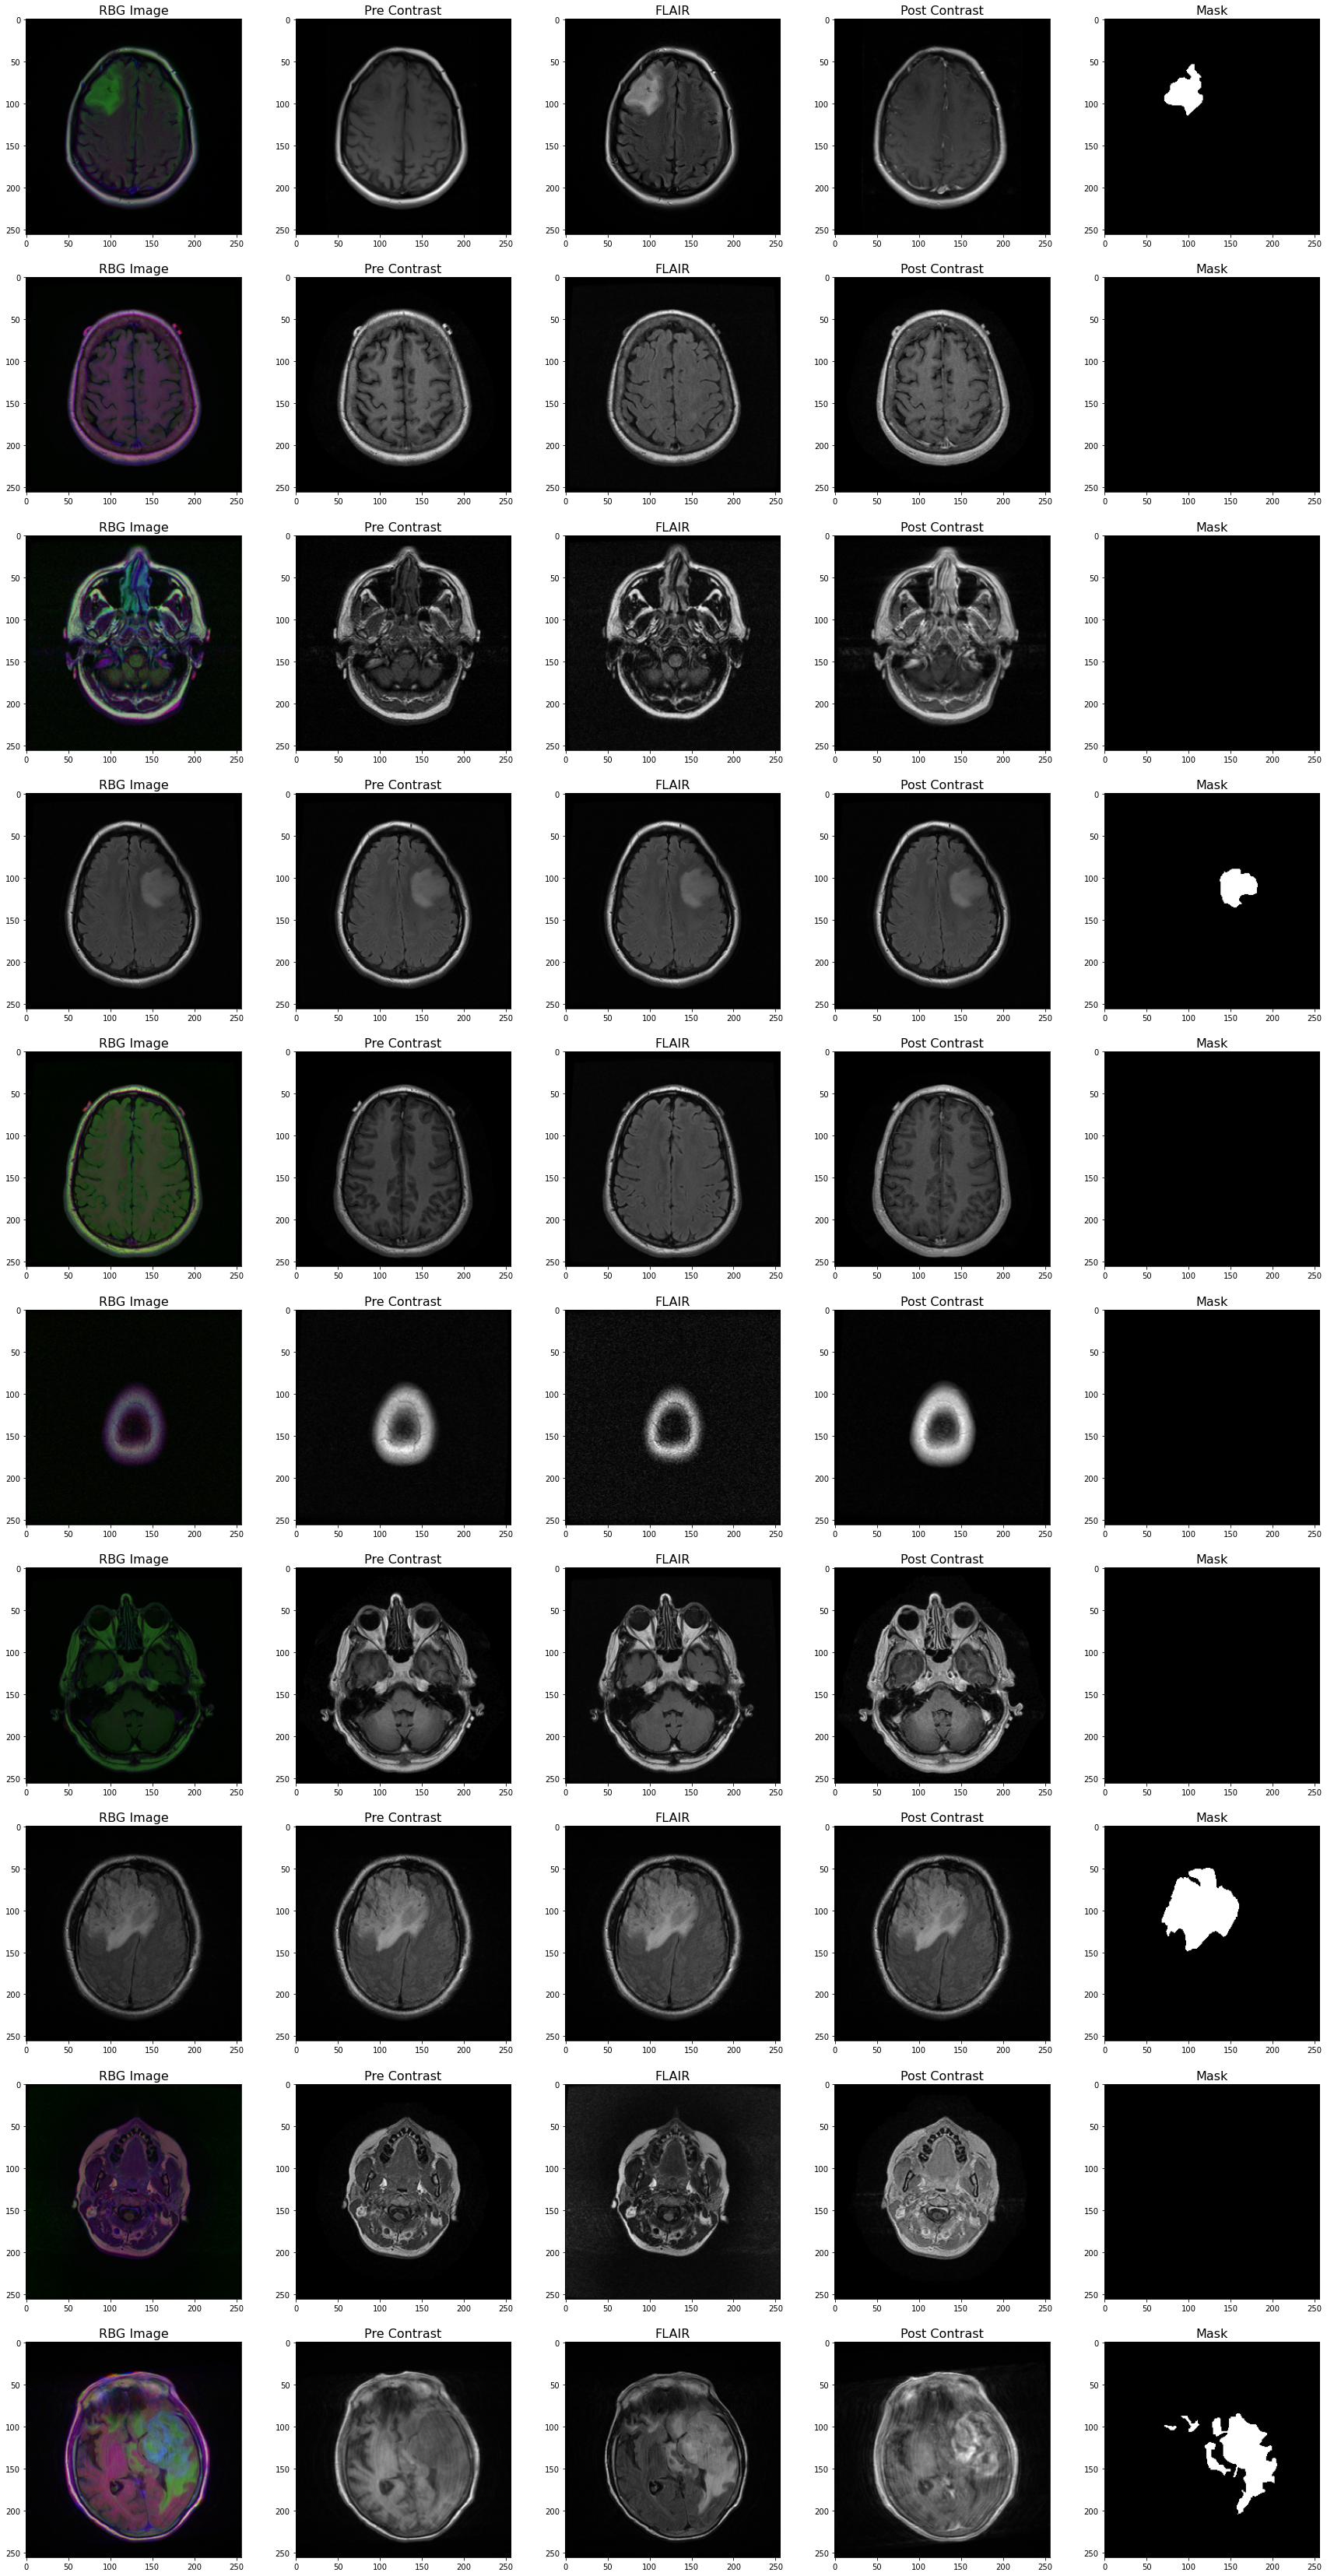

In [9]:
plt.figure(figsize=(30,60))

for j in range(0, 10):
    index = random.randrange(0, 1000, 3)
    
    mri = np.asarray(load_img(
         join(DIR, train_df['mris'][index]), 
         target_size=(SIZE, SIZE)))
    mask = np.asarray(load_img(
        join(DIR, train_df['masks'][index]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
             
    images = [mri, mri[:,:,0], mri[:,:,1], mri[:,:,2], mask]
    titles = ["RBG Image", "Pre Contrast", "FLAIR", "Post Contrast", "Mask"]
    
    for i in range(0, 5):
        ax = plt.subplot(10, 5, (j*5)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')

plt.show()

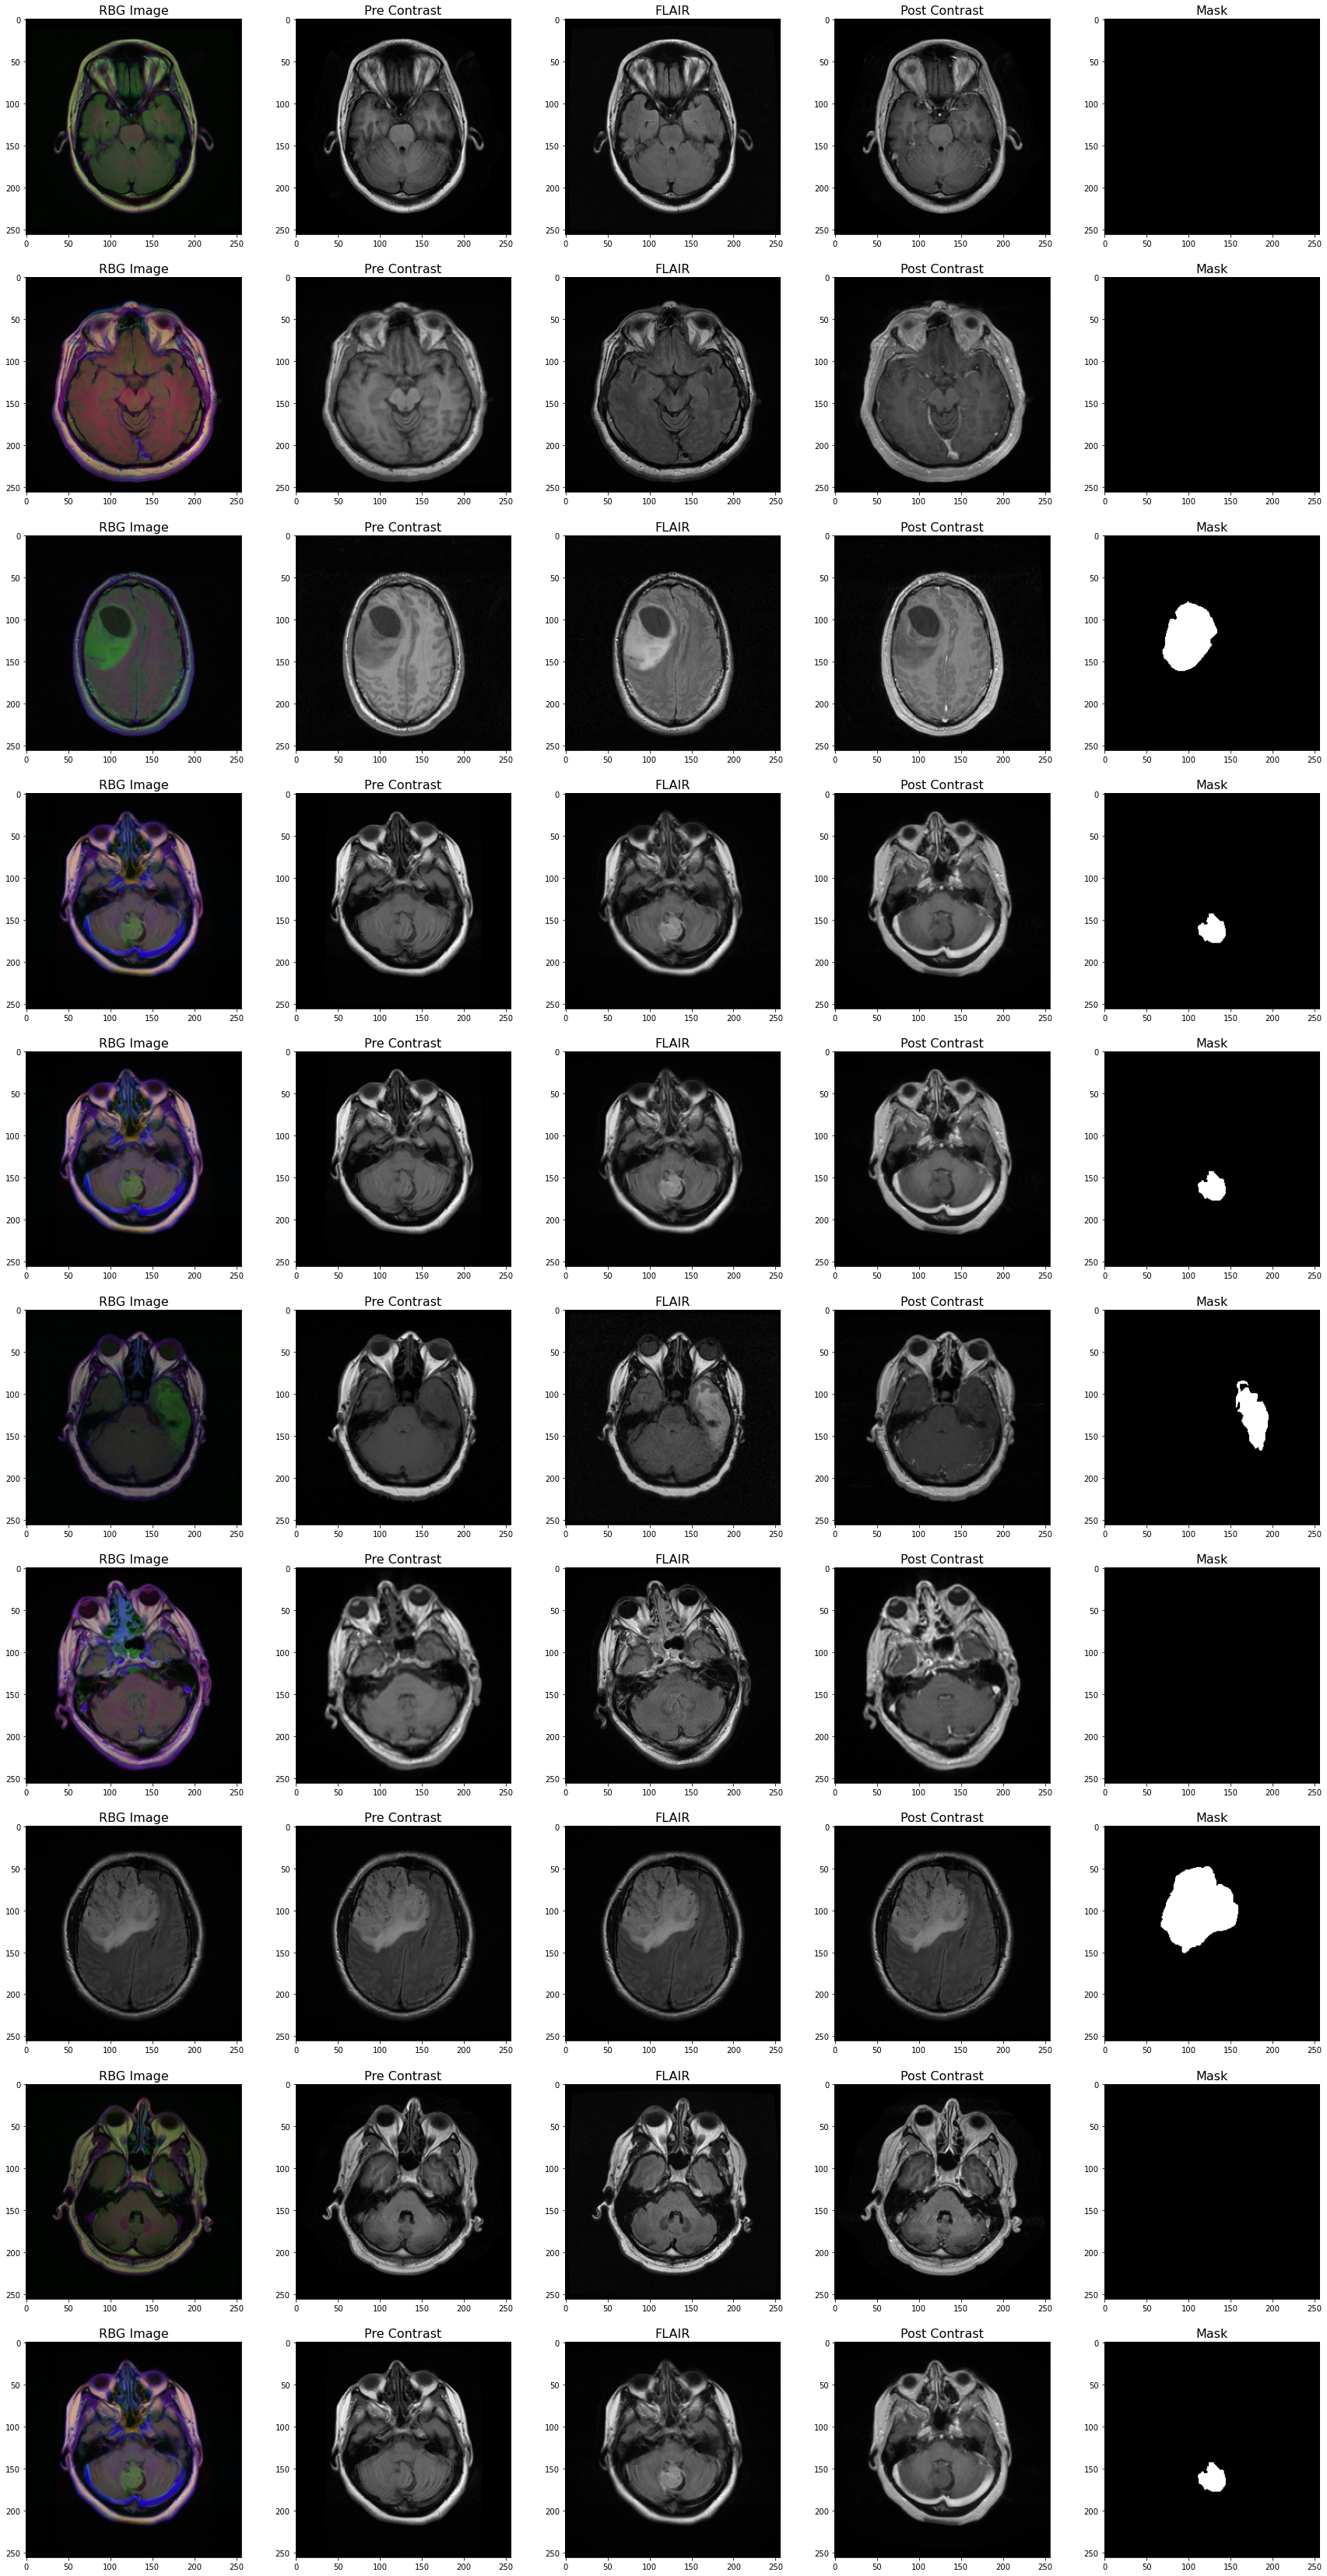

In [10]:
plt.figure(figsize=(30,60))

for j in range(0, 10):
    index = random.randrange(0, 200, 3)
    
    mri = np.asarray(load_img(
         join(DIR, val_df['mris'][index]), 
         target_size=(SIZE, SIZE)))
    mask = np.asarray(load_img(
        join(DIR, val_df['masks'][index]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
             
    images = [mri, mri[:,:,0], mri[:,:,1], mri[:,:,2], mask]
    titles = ["RBG Image", "Pre Contrast", "FLAIR", "Post Contrast", "Mask"]
    
    for i in range(0, 5):
        ax = plt.subplot(10, 5, (j*5)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')

plt.show()

In [11]:
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)
class BrainMRIs(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, directory):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.directory = directory

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(join(self.directory, path), target_size=(self.img_size, self.img_size))
            x[j] = img
            
        y = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(join(self.directory, path), target_size=(self.img_size, self.img_size), color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        
        return adjust_data(x, y)

In [12]:
train_gen = BrainMRIs(BATCH_SIZE, SIZE, train_images, train_targets, DIR)
val_gen = BrainMRIs(BATCH_SIZE, SIZE, val_images, val_targets, DIR)
test_gen = BrainMRIs(BATCH_SIZE, SIZE, test_images, test_targets, DIR)

In [13]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef = keras.backend.flatten(y_true)
    y_predf = keras.backend.flatten(y_pred)
    And = keras.backend.sum(y_truef*y_predf)
    return((2* And + smooth) / (keras.backend.sum(y_truef) + keras.backend.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = keras.backend.sum(y_true * y_pred)
    sum_ = keras.backend.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef = keras.backend.flatten(y_true)
    y_predf = keras.backend.flatten(y_pred)

    return - iou(y_true, y_pred)

In [14]:
inputs = layers.Input((SIZE, SIZE, INPUT_CHANNELS))

c1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
c1 = layers.Dropout(0.2)(c1)
c1 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', name="conv1_2")(c1)
c1 = layers.BatchNormalization(axis=3)(c1)
c1 = layers.Activation('relu')(c1)
input_1 = layers.MaxPooling2D((2, 2))(c1)
c2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2_1')(input_1)
c2 = layers.Dropout(0.2)(c2)
c2 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name="conv2_2")(c2)
c2 = layers.BatchNormalization(axis=3)(c2)
c2 = layers.Activation('relu')(c2)
input_2 = layers.MaxPooling2D((2, 2))(c2)
c3 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv3_1')(input_2)
c3 = layers.Dropout(0.2)(c3)
c3 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name="conv3_2")(c3)
c3 = layers.BatchNormalization(axis=3)(c3)
c3 = layers.Activation('relu')(c3)
input_3 = layers.MaxPooling2D((2, 2))(c3)
c4 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv4_1')(input_3)
c4 = layers.Dropout(0.2)(c4)
c4 = layers.Conv2D(256, kernel_size=(3, 3), padding='same', name="conv4_2")(c4)
c4 = layers.BatchNormalization(axis=3)(c4)
c4 = layers.Activation('relu')(c4)
input_4 = layers.MaxPooling2D((2, 2))(c4)

c5 = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='conv5_1')(input_4)
c5 = layers.Dropout(0.2)(c5)
c5 = layers.Conv2D(512, kernel_size=(3, 3), padding='same', name="conv5_2")(c5)
c5 = layers.BatchNormalization(axis=3)(c5)
c5 = layers.Activation('relu')(c5)
u6 = layers.Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv6_1')(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv6_2')(u6)
c6 = layers.Dropout(0.2)(c6)
c6 = layers.Conv2D(256, kernel_size=(3, 3), padding='same', name="conv6_3")(c6)
c6 = layers.BatchNormalization(axis=3)(c6)
c6 = layers.Activation('relu')(c6)

u7 = layers.Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv7_1')(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv7_2')(u7)
c7 = layers.Dropout(0.2)(c7)
c7 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name="conv7_3")(c7)
c7 = layers.BatchNormalization(axis=3)(c7)
c7 = layers.Activation('relu')(c7)
u8 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv8_1')(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv8_2')(u8)
c8 = layers.Dropout(0.2)(c8)
c8 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name="conv8_3")(c8)
c8 = layers.BatchNormalization(axis=3)(c8)
c8 = layers.Activation('relu')(c8)

u9 = layers.Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv9_1')(c8)
u9 = layers.concatenate([u9, c1])
c9 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv9_2')(u9)
c9 = layers.Dropout(0.2)(c9)
c9 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', name="conv9_3")(c9)
c9 = layers.BatchNormalization(axis=3)(c9)
c9 = layers.Activation('relu')(c9)

outputs = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', padding='same', name="output")(c9)
# img_file = './model_arch.png'
# tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)
model = keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv1_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [15]:
EPOCHS = 30
learning_rate = 1e-2
decay_rate = learning_rate / 10

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=learning_rate, 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=None, 
        decay=decay_rate, 
        amsgrad=False), 
    loss=dice_coef_loss,
    metrics=["binary_accuracy", iou, dice_coef])

model_checkpoint = keras.callbacks.ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)
#early_stopping  = keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)

history = model.fit(
    train_gen, 
    validation_data=val_gen,
    epochs=100,
    callbacks=[model_checkpoint])

Epoch 1/100
94/94 [==============================] - 34s 293ms/step - loss: -0.3194 - binary_accuracy: 0.9526 - iou: 0.2031 - dice_coef: 0.3194 - val_loss: -0.1853 - val_binary_accuracy: 0.9399 - val_iou: 0.1039 - val_dice_coef: 0.1853

Epoch 00001: val_loss improved from inf to -0.18532, saving model to unet_brain_mri_seg.hdf5
Epoch 2/100
94/94 [==============================] - 28s 293ms/step - loss: -0.4771 - binary_accuracy: 0.9892 - iou: 0.3243 - dice_coef: 0.4771 - val_loss: -0.0243 - val_binary_accuracy: 0.2518 - val_iou: 0.0124 - val_dice_coef: 0.0243

Epoch 00002: val_loss did not improve from -0.18532
Epoch 3/100
94/94 [==============================] - 28s 292ms/step - loss: -0.6017 - binary_accuracy: 0.9923 - iou: 0.4404 - dice_coef: 0.6017 - val_loss: -0.1860 - val_binary_accuracy: 0.9268 - val_iou: 0.1038 - val_dice_coef: 0.1860

Epoch 00003: val_loss improved from -0.18532 to -0.18602, saving model to unet_brain_mri_seg.hdf5
Epoch 4/100
94/94 [===========================

94/94 [==============================] - 29s 305ms/step - loss: -0.8165 - binary_accuracy: 0.9964 - iou: 0.6934 - dice_coef: 0.8165 - val_loss: -0.7802 - val_binary_accuracy: 0.9960 - val_iou: 0.6461 - val_dice_coef: 0.7802

Epoch 00027: val_loss improved from -0.76855 to -0.78020, saving model to unet_brain_mri_seg.hdf5
Epoch 28/100
94/94 [==============================] - 27s 290ms/step - loss: -0.8273 - binary_accuracy: 0.9966 - iou: 0.7084 - dice_coef: 0.8273 - val_loss: -0.7777 - val_binary_accuracy: 0.9957 - val_iou: 0.6419 - val_dice_coef: 0.7777

Epoch 00028: val_loss did not improve from -0.78020
Epoch 29/100
94/94 [==============================] - 27s 290ms/step - loss: -0.8294 - binary_accuracy: 0.9967 - iou: 0.7118 - dice_coef: 0.8294 - val_loss: -0.7740 - val_binary_accuracy: 0.9958 - val_iou: 0.6381 - val_dice_coef: 0.7740

Epoch 00029: val_loss did not improve from -0.78020
Epoch 30/100
94/94 [==============================] - 27s 290ms/step - loss: -0.8273 - binary_acc

94/94 [==============================] - 28s 293ms/step - loss: -0.8731 - binary_accuracy: 0.9975 - iou: 0.7772 - dice_coef: 0.8731 - val_loss: -0.8301 - val_binary_accuracy: 0.9970 - val_iou: 0.7147 - val_dice_coef: 0.8301

Epoch 00053: val_loss improved from -0.82860 to -0.83007, saving model to unet_brain_mri_seg.hdf5
Epoch 54/100
94/94 [==============================] - 28s 293ms/step - loss: -0.8734 - binary_accuracy: 0.9975 - iou: 0.7778 - dice_coef: 0.8734 - val_loss: -0.8198 - val_binary_accuracy: 0.9967 - val_iou: 0.7003 - val_dice_coef: 0.8198

Epoch 00054: val_loss did not improve from -0.83007
Epoch 55/100
94/94 [==============================] - 28s 293ms/step - loss: -0.8738 - binary_accuracy: 0.9975 - iou: 0.7784 - dice_coef: 0.8738 - val_loss: -0.8335 - val_binary_accuracy: 0.9971 - val_iou: 0.7194 - val_dice_coef: 0.8335

Epoch 00055: val_loss improved from -0.83007 to -0.83352, saving model to unet_brain_mri_seg.hdf5
Epoch 56/100
94/94 [==============================]

94/94 [==============================] - 27s 292ms/step - loss: -0.8914 - binary_accuracy: 0.9979 - iou: 0.8064 - dice_coef: 0.8914 - val_loss: -0.8276 - val_binary_accuracy: 0.9969 - val_iou: 0.7126 - val_dice_coef: 0.8276

Epoch 00080: val_loss did not improve from -0.83930
Epoch 81/100
94/94 [==============================] - 27s 292ms/step - loss: -0.8885 - binary_accuracy: 0.9978 - iou: 0.8016 - dice_coef: 0.8885 - val_loss: -0.8361 - val_binary_accuracy: 0.9971 - val_iou: 0.7243 - val_dice_coef: 0.8361

Epoch 00081: val_loss did not improve from -0.83930
Epoch 82/100
94/94 [==============================] - 27s 292ms/step - loss: -0.8921 - binary_accuracy: 0.9979 - iou: 0.8074 - dice_coef: 0.8921 - val_loss: -0.8392 - val_binary_accuracy: 0.9972 - val_iou: 0.7276 - val_dice_coef: 0.8392

Epoch 00082: val_loss did not improve from -0.83930
Epoch 83/100
94/94 [==============================] - 27s 292ms/step - loss: -0.8936 - binary_accuracy: 0.9979 - iou: 0.8099 - dice_coef: 0.893

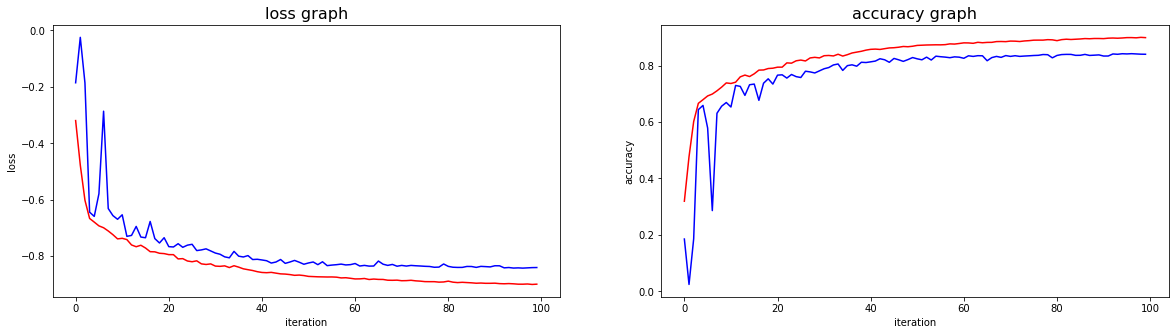

In [17]:
a = history.history

list_trainloss = a['loss']
list_testloss = a['val_loss']
list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

plt.figure(figsize=(20,5))

ax = plt.subplot(1, 2, 1)
ax.set_title('loss graph', fontsize = 16)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')

ax = plt.subplot(1, 2, 2)
ax.set_title('accuracy graph', fontsize = 16)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')

plt.show()

In [18]:
x = np.zeros((15, SIZE, SIZE, 3), dtype="float32")   
disp_x = np.zeros((15, SIZE, SIZE, 3), dtype="uint8")
y = np.zeros((15, SIZE, SIZE, 1), dtype="uint8")

for j in range(0, 15):
    x[j] = np.asarray(load_img(
         join(DIR, test_df['mris'][j]), 
         target_size=(SIZE, SIZE)))
    disp_x[j] = x[j]
    img = np.asarray(load_img(
        join(DIR, test_df['masks'][j]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
    y[j] = np.expand_dims(img, 2)

In [19]:
model = keras.models.load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
preds = model.predict(x / 255)

In [20]:
preds_t = (preds > 0.5).astype(np.uint8)
print(np.amax(preds))
print(np.amax(preds_t))
print(preds.shape)

print(np.unique(preds_t, return_counts=True))

1.0
1
(15, 256, 256, 1)
(array([0, 1], dtype=uint8), array([964862,  18178]))


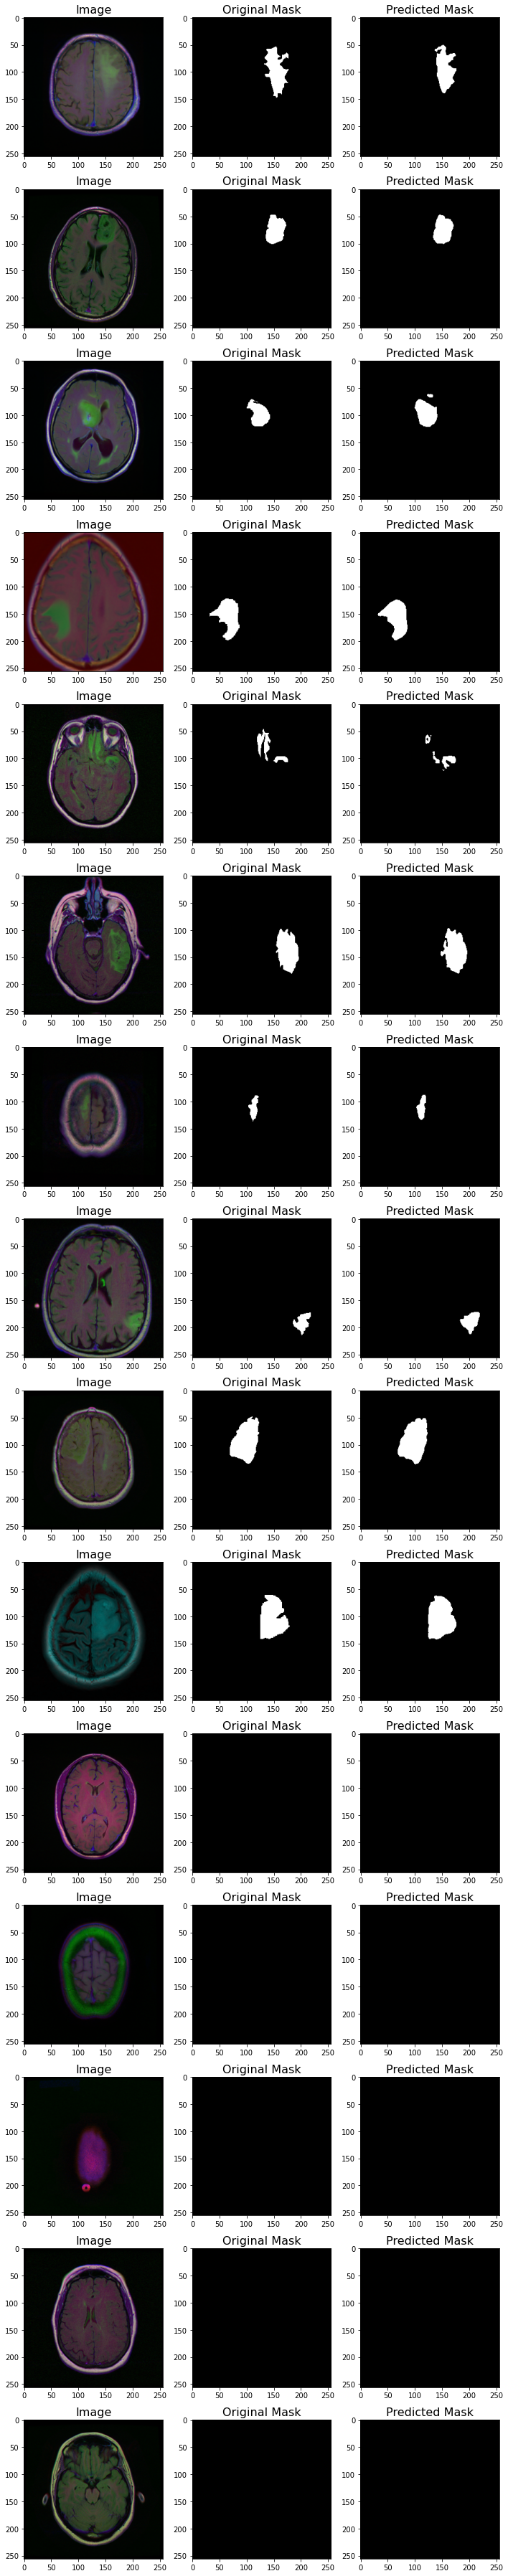

In [21]:
plt.figure(figsize=(10,50))

titles = ["Image", "Original Mask", "Predicted Mask"]

for j in range(15):
    images = [disp_x[j], y[j], preds_t[j]**255]
    for i in range(0, 3):
        ax = plt.subplot(15, 3, (j*3)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')
        
plt.tight_layout()
plt.show()